In [173]:
import os
import sys
import random
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
from google.colab import files
import pandas as pd
from pandas.plotting import scatter_matrix
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from itertools import permutations

In [174]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=pd.errors.ChainedAssignmentError)
warnings.filterwarnings("ignore", category=FutureWarning)

drive.mount('/content/drive/')

DATA_FOLDER  = "drive/MyDrive/MO-homeworks/dataset/"
TRAIN_FOLDER = DATA_FOLDER + "train.csv"
TEST_FOLDER  = DATA_FOLDER + "test.csv"
HEAD = "ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score"
COLUMNS = HEAD.split(",")
EXTRA_COLUMNS = ['ID', 'Customer_ID', 'Name', 'SSN']

# Количество записей, которые будут использованы для обучения
DATA_SIZE = 10000

def load_data(file):
  data = pd.read_csv(file, sep=',', header=None,  engine='python')[1:]
  data = data[:DATA_SIZE]
  data.columns = COLUMNS
  data = data.reset_index(drop=True)
  for extra_column in EXTRA_COLUMNS:
    data = data.drop(extra_column, axis=1)
  return data

def load_train():
  return load_data(TRAIN_FOLDER)

def load_test():
  # тестовые данные не содержат кредитный рейтинг (класс)
  return load_data(TEST_FOLDER)

def load_all():
  return pd.concat([load_train(), load_test()])

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [175]:
# ID - уникальный идентификатор записи
# Customer_ID - уникальный идентификатор человека
# Month - месяц, в котором данные были актуальны
# Name - имя человека
# Age - возраст, в котором данные были актуальны
# SSN - номер социального страхования человека
# Occupation - профессия
# Annual_Income - годовой доход
# Monthly_Inhand_Salary - месячная заработная плата
# Num_Credit_Card - количество кредитных карт
# Interest_Rate - процентная ставка по кредитной карте
# Num_of_loan - количество кредитов, взятых в банке
# Num_Of_Delayed_Payment - среднее количество дней задержки с даты платежа
# Changed_Credit_Limit - процентное изменение лимита кредитной карты
# Num_Credit_Inquires = количество запросов по кредитным картам
# Credit_Mic - классификация набора кредитов (Good, Standard, Bad)
# Outstanding_Debt = оставшаяся сумма задолженности США
# Credit_Utilization_Ratio - коэффициент использования кредитной краты
# Credit_History_Age - возраст кредитной истории
# Payment_of_min_Amont - была ли лицом уплачена только минимальная сумма
# Total_EMI_Per_Month = ежемесячный платеж по кредиту
# Amount_invested_Monthly - колько было инвестировано клиентом в месяц
# Payment_Behaviour - платежное поведение
# Monthly_Balance - ежемесячная сумма баланса клиента

# Классификация:
# Credit_Score: Good, Standard, Poor

# Задача заключается в определении кредитного рейтинга по 26 (23) параметрам

In [176]:
data = load_train()

In [177]:
data

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,January,23,Scientist,19114.12,1824.8433333333328,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,_,809.98,26.822619623699016,22 Years and 1 Months,No,49.57494921489417,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,February,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.94496005538421,NaN,No,49.57494921489417,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,March,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,28.60935202206993,22 Years and 3 Months,No,49.57494921489417,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,April,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.377861869582354,22 Years and 4 Months,No,49.57494921489417,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,May,23,Scientist,19114.12,1824.8433333333328,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,24.797346908844986,22 Years and 5 Months,No,49.57494921489417,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,April,21,Teacher,16603.43,1205.6191666666666,8,10,30,3_,"Student Loan, Payday Loan, and Home Equity Loan",...,Standard,2056.83,25.6527024967421,11 Years and 4 Months,Yes,31.855732480323802,68.46394020724118,High_spent_Small_value_payments,280.24224397910166,Poor
9996,May,21,Teacher,16603.43,1205.6191666666666,8,10,30,-100,"Student Loan, Payday Loan, and Home Equity Loan",...,Standard,2056.83,27.943271290456572,11 Years and 5 Months,Yes,31.855732480323802,33.658272401338785,Low_spent_Medium_value_payments,335.04791178500415,Poor
9997,June,21,Teacher,16603.43,1205.6191666666666,8,10,30,3,"Student Loan, Payday Loan, and Home Equity Loan",...,Standard,2056.83,31.622953885824828,11 Years and 6 Months,Yes,31.855732480323802,54.85392284573754,!@9#%8,313.8522613406053,Poor
9998,July,21,Teacher,16603.43,1205.6191666666666,8,10,30,3,"Student Loan, Payday Loan, and Home Equity Loan",...,_,2056.83,26.851964715747425,11 Years and 7 Months,Yes,31.855732480323802,69.68451157392317,Low_spent_Small_value_payments,309.0216726124197,Poor


In [178]:
# Приведение всех пропущенных значений к одному символу _
data = data.replace("NA", "_")
data = data.replace("_______", "_")
data = data.replace("NM", "_")
for column in data.columns:
  # встречаются числовые значения вида "647.23_", нужно убрать подчеркивание
  for i in range(data.shape[0]):
    if type(data[column][i]) == str and data[column][i][len(data[column][i]) - 1] == "_" and len(data[column][i]) > 1:
      data[column][i] = data[column][i][0:len(data[column][i]) - 1]

data = data.convert_dtypes()
data = data.infer_objects()

In [179]:
# Приведение возраста кредитной истории в формате "1 год 2 месяца" к числовому значению

numbers = [str(i) for i in range(0, 10)]
numbers.append(" ")

for i in range(data.shape[0]):
  credit_age = data['Credit_History_Age'][i]
  credit_age_processed = ""
  if (type(credit_age) == pd._libs.missing.NAType):
    continue
  for j in range(len(credit_age)):
    if credit_age[j] in numbers:
      credit_age_processed += credit_age[j]
  credit_age_arr = list(credit_age_processed.split())
  credit_age_new = 0.0
  if len(credit_age_arr) > 0:
    credit_age_new += float(credit_age_arr[0])
  if len(credit_age_arr) > 1:
    credit_age_new += float(credit_age_arr[1]) / 12.0

  data['Credit_History_Age'][i] = str(credit_age_new)

print()

In [180]:
# приведение столбцов к нужному типу и обработка некоторых выбросов

for column in data.columns:
  try:
    data[column] = pd.to_numeric(data[column], errors='ignore')
    data[column][data[column] < 0] = 0
  except:
    pass

data['Age'][data['Age'] > 105] = 0


array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Annual_Income', ylabel='Age'>,
        <Axes: xlabel='Monthly_Inhand_Salary', ylabel='Age'>,
        <Axes: xlabel='Num_Bank_Accounts', ylabel='Age'>,
        <Axes: xlabel='Num_Credit_Card', ylabel='Age'>,
        <Axes: xlabel='Interest_Rate', ylabel='Age'>,
        <Axes: xlabel='Num_of_Loan', ylabel='Age'>,
        <Axes: xlabel='Delay_from_due_date', ylabel='Age'>,
        <Axes: xlabel='Num_of_Delayed_Payment', ylabel='Age'>,
        <Axes: xlabel='Num_Credit_Inquiries', ylabel='Age'>,
        <Axes: xlabel='Outstanding_Debt', ylabel='Age'>,
        <Axes: xlabel='Credit_Utilization_Ratio', ylabel='Age'>,
        <Axes: xlabel='Credit_History_Age', ylabel='Age'>,
        <Axes: xlabel='Total_EMI_per_month', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Annual_Income'>,
        <Axes: xlabel='Annual_Income', ylabel='Annual_Income'>,
        <Axes: xlabel='Monthly_Inhand_Salary', ylabel='Annual_Income'>,
    

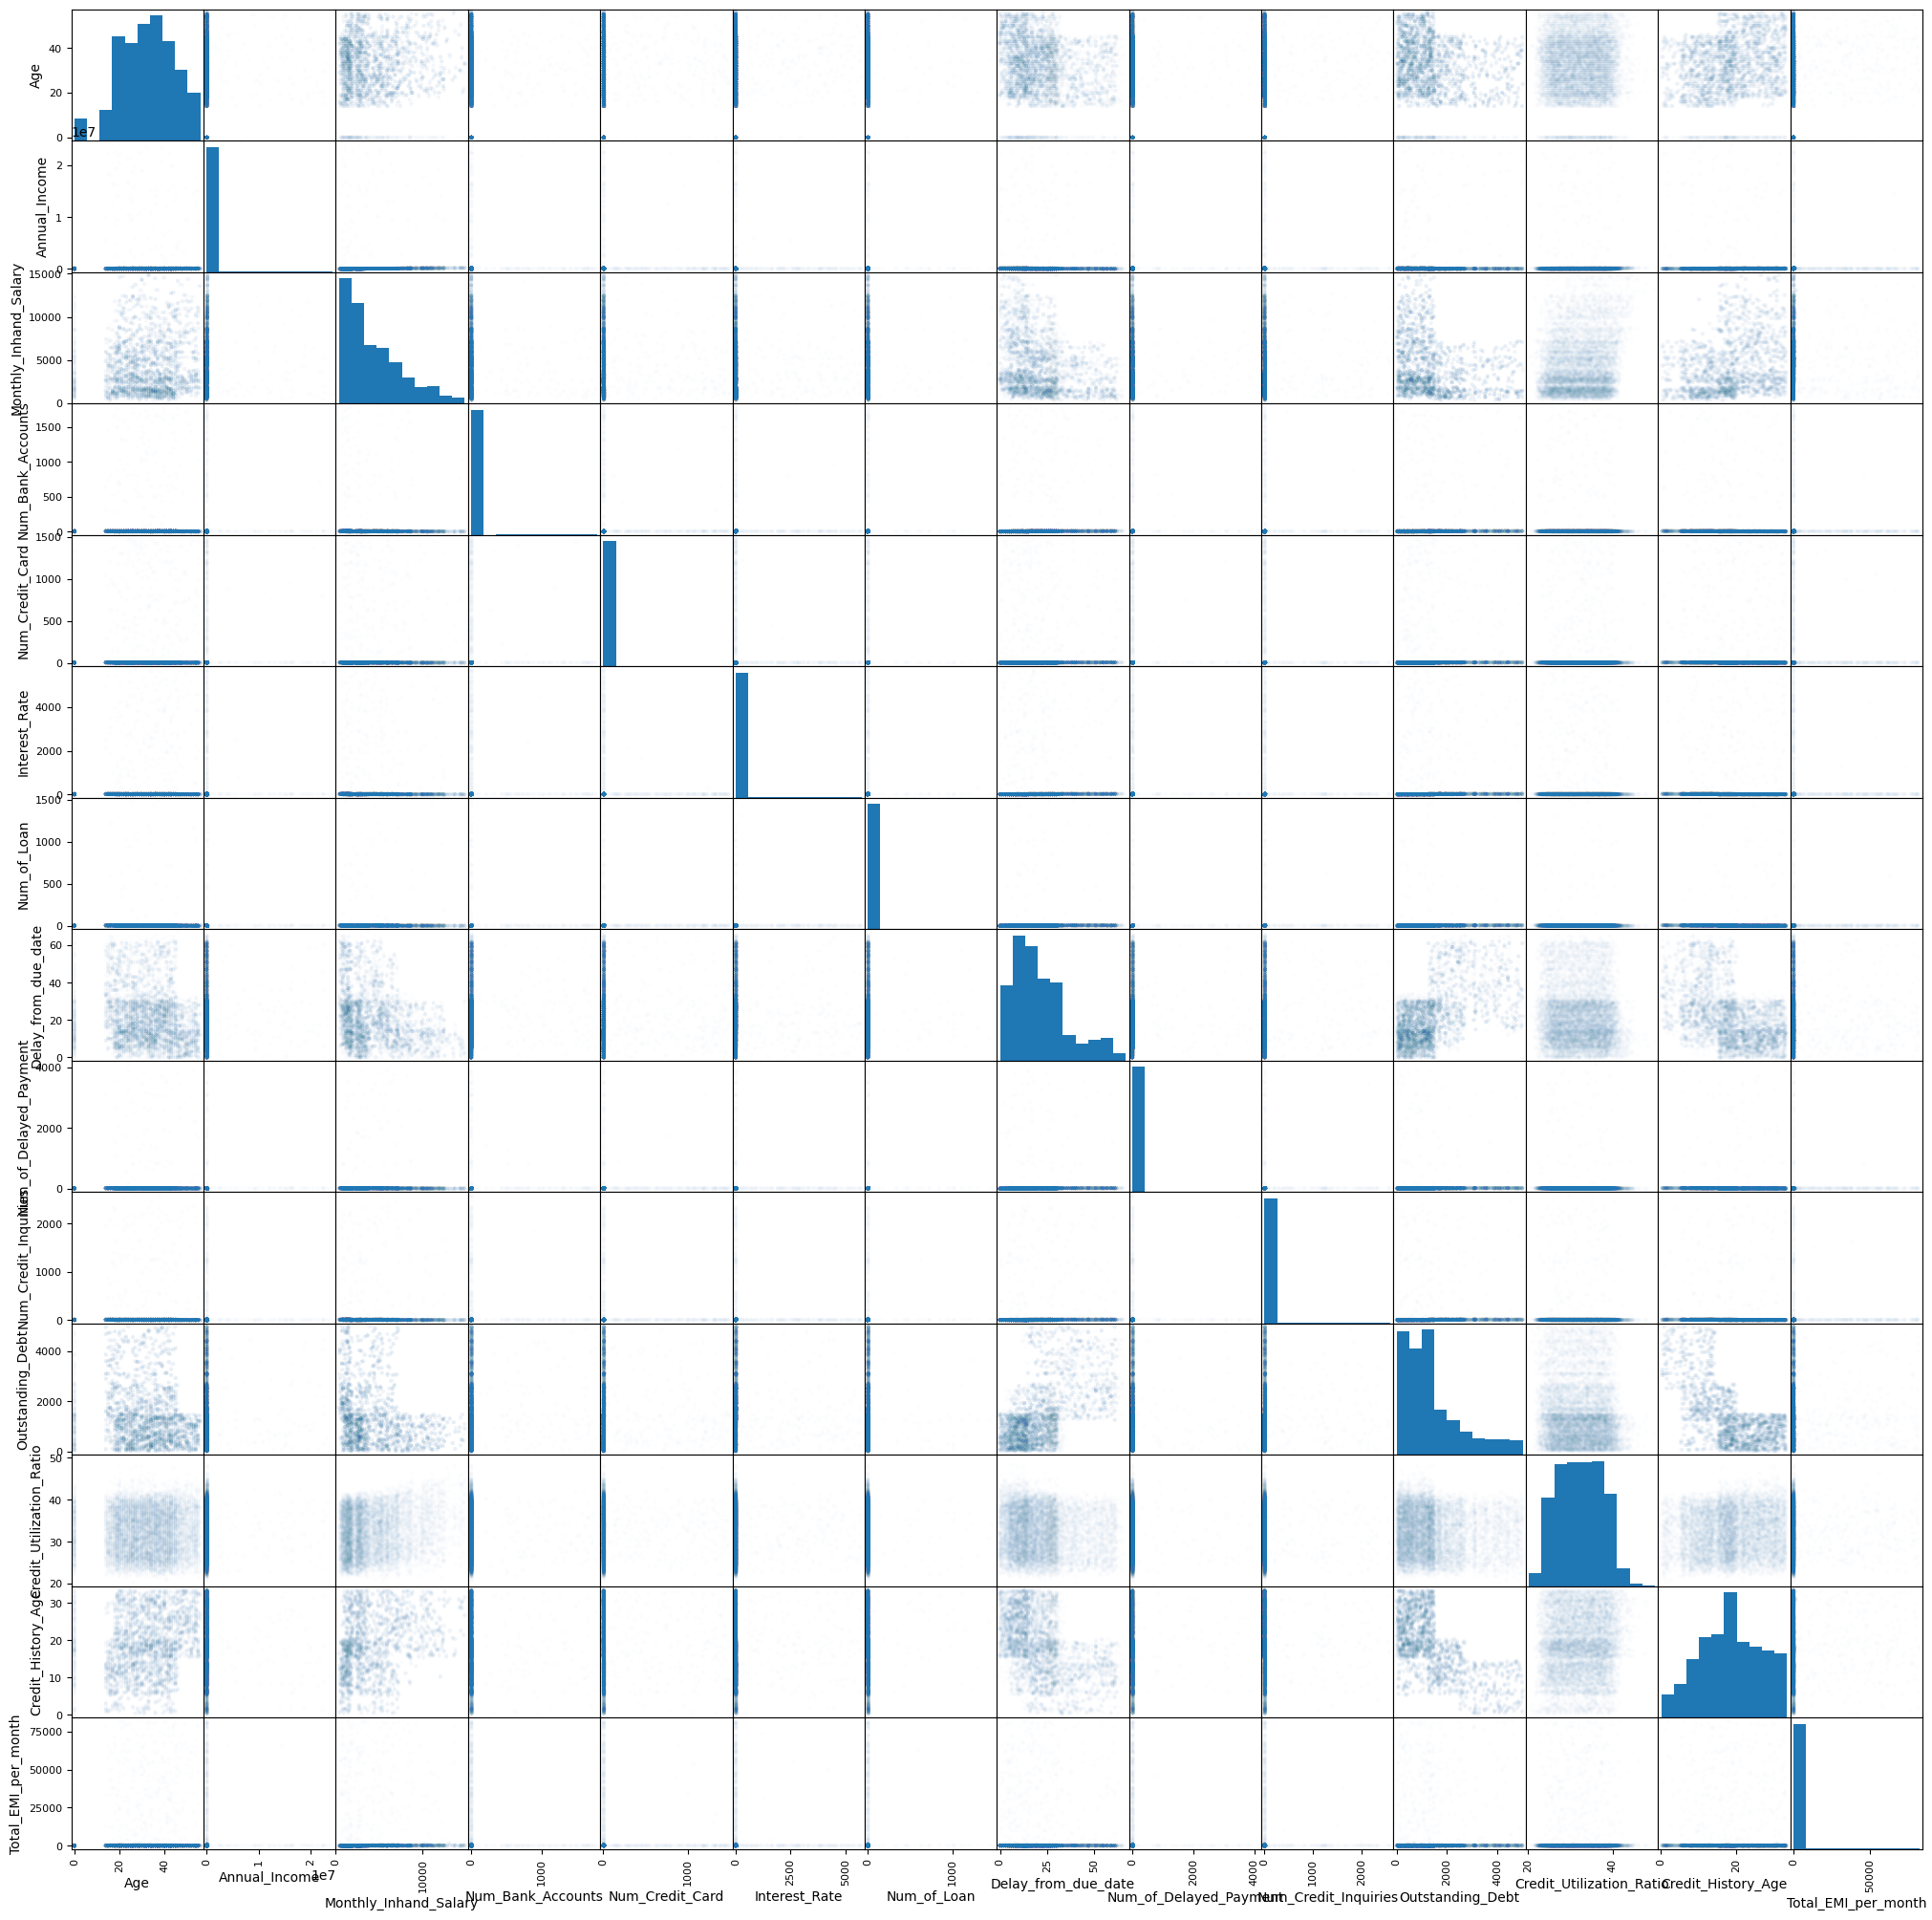

In [181]:
scatter_matrix(data, alpha = .01, figsize = (25, 25))

In [182]:
data.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month
count,10000.0,10000.0,8533.0,10000.0,10000.0,10000.0,10000.0,10000.0,9292.0,9791.0,10000.0,10000.0,9068.0,10000.0
mean,32.4061,172118.115091,4327.365651,17.5836,24.8283,74.4557,6.4764,21.31,28.511192,24.470228,1413.42428,32.287267,18.661493,1399.238658
std,12.037877,1389360.122435,3213.718684,122.790914,140.202803,470.664749,53.711974,14.602336,202.787154,176.195902,1174.382522,5.155147,8.125101,8213.170285
min,0.0,7006.52,355.208333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.48,20.172942,0.083333,0.0
25%,24.0,20081.52,1684.832083,3.0,4.0,7.0,2.0,10.0,9.0,3.0,530.51,27.97101,12.583333,28.386074
50%,33.0,39696.98,3278.709167,6.0,5.0,14.0,3.0,18.0,14.0,5.0,1126.905,32.270723,18.5,67.45026
75%,41.0,75273.24,6155.64,8.0,7.0,20.0,5.0,28.0,18.0,9.0,1901.28,36.527702,25.25,165.335553
max,56.0,24188807.0,14836.736667,1789.0,1486.0,5721.0,1485.0,67.0,4128.0,2592.0,4998.07,50.0,33.666667,82204.0


In [183]:
data.select_dtypes(include=[float, int]).corr()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month
Age,1.000000,-0.011475,0.054486,-0.016801,-0.005853,0.007232,-0.019114,-0.174122,0.004738,-0.000583,-0.175713,0.009339,0.211987,0.009165
Annual_Income,-0.011475,1.000000,0.016889,0.000212,0.025772,-0.008152,-0.004154,0.003232,-0.006159,-0.008680,0.021858,0.017232,-0.019251,-0.003126
Monthly_Inhand_Salary,0.054486,0.016889,1.000000,-0.027224,-0.010823,-0.014044,-0.005089,-0.290543,-0.011786,-0.001449,-0.252178,0.171507,0.273048,-0.000849
Num_Bank_Accounts,-0.016801,0.000212,-0.027224,1.000000,0.014895,-0.000997,-0.004944,0.032214,0.001831,0.001600,0.044423,-0.011928,-0.030592,-0.012250
Num_Credit_Card,-0.005853,0.025772,-0.010823,0.014895,1.000000,-0.014610,-0.008040,0.003356,0.008661,-0.014552,0.005424,0.010205,-0.006023,0.003354
Interest_Rate,0.007232,-0.008152,-0.014044,-0.000997,-0.014610,1.000000,-0.005690,0.014432,-0.004846,-0.013249,0.008284,-0.004872,-0.005154,-0.007448
Num_of_Loan,-0.019114,-0.004154,-0.005089,-0.004944,-0.008040,-0.005690,1.000000,0.028466,-0.003529,0.002754,0.023546,-0.009998,-0.006325,-0.000163
Delay_from_due_date,-0.174122,0.003232,-0.290543,0.032214,0.003356,0.014432,0.028466,1.000000,0.013775,0.025027,0.562107,-0.064626,-0.474608,-0.008855
Num_of_Delayed_Payment,0.004738,-0.006159,-0.011786,0.001831,0.008661,-0.004846,-0.003529,0.013775,1.000000,0.015202,-0.003874,-0.009863,-0.014204,-0.009316
Num_Credit_Inquiries,-0.000583,-0.008680,-0.001449,0.001600,-0.014552,-0.013249,0.002754,0.025027,0.015202,1.000000,0.019439,-0.016370,-0.014176,-0.009460


In [184]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'string']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'string']
int_columns         = [c for c in data.columns if data[c].dtype.name == 'Int64']
float_columns       = [c for c in data.columns if data[c].dtype.name == 'Float64']
print(categorical_columns)
print(numerical_columns)
print(int_columns)
print(float_columns)

['Month', 'Occupation', 'Type_of_Loan', 'Changed_Credit_Limit', 'Credit_Mix', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']
['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month']
['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment']
['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month']


In [185]:
# некоторая обработка численных признаков перед категоризацией

for float_column in float_columns:
  data[float_column] = data[float_column].fillna(data[float_column].mean())

for int_column in int_columns:
  data[int_column] = data[int_column].fillna(int(data[int_column].mean())).astype('Int64')

data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].astype('Int64')

In [186]:
# обработка категориальных признаков

for categorical_column in categorical_columns:
  data[categorical_column] = data[categorical_column].fillna('_')
  unique, counts = np.unique(data[categorical_column][data[categorical_column] != '_'], return_counts=True)
  most_common_value = unique[np.argmax(counts)]
  data[categorical_column][data[categorical_column] == '_'] = most_common_value

category_mapping = {}

for categorical_column in categorical_columns:
    data[categorical_column] = pd.Categorical(data[categorical_column])
    category_mapping[categorical_column] = dict(enumerate(data[categorical_column].cat.categories))
    data[categorical_column] = data[categorical_column].cat.codes

In [187]:
# нормализация

data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

data_categorical = pd.get_dummies(data[categorical_columns])

data = pd.concat((data_numerical, data_categorical), axis = 1)

In [188]:
# X и y

X = data.drop('Credit_Score', axis=1)
y = data['Credit_Score']
feature_names = X.columns

X = X.to_numpy()
y = y.to_numpy()

In [189]:
print(X.shape, y.shape)

(10000, 23) (10000,)


In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape
N, d = X.shape

print(N_train, N_test)

7000 3000


In [191]:
# Для решения задачи классификации кредитных рейтингов был выбран алгоритм Random Forest,
# поскольку он продемонстрировал наилучшие результаты по сравнению с рядом других методов,
# включая K-ближайшие соседи (KNN), метод опорных векторов (SVC), Extremely Randomized Trees, AdaBoost и Gradient Boosting Trees (GBT).

from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 2000)
rf.fit(X_train, y_train)

predictedTrain = rf.predict(X_train)
predictedTest = rf.predict(X_test)

err_train = np.mean(y_train != predictedTrain)
err_test  = np.mean(y_test  != predictedTest)

print(err_train, err_test)

0.0 0.20966666666666667


In [192]:
np.sum(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
 1. feature 'Outstanding_Debt' (0.100032)
 2. feature 'Interest_Rate' (0.081637)
 3. feature 'Credit_History_Age' (0.062423)
 4. feature 'Delay_from_due_date' (0.060679)
 5. feature 'Credit_Mix' (0.050237)
 6. feature 'Changed_Credit_Limit' (0.044833)
 7. feature 'Monthly_Balance' (0.044180)
 8. feature 'Num_Credit_Inquiries' (0.043950)
 9. feature 'Num_of_Delayed_Payment' (0.042665)
10. feature 'Credit_Utilization_Ratio' (0.042240)
11. feature 'Annual_Income' (0.040008)
12. feature 'Amount_invested_monthly' (0.039618)
13. feature '  Age' (0.039344)
14. feature 'Total_EMI_per_month' (0.038984)
15. feature 'Type_of_Loan' (0.038581)
16. feature 'Monthly_Inhand_Salary' (0.037869)
17. feature 'Num_Credit_Card' (0.036385)
18. feature 'Num_Bank_Accounts' (0.033867)
19. feature 'Occupation' (0.027977)
20. feature 'Month' (0.027062)
21. feature 'Num_of_Loan' (0.025213)
22. feature 'Payment_Behaviour' (0.023491)
23. feature 'Payment_of_Min_Amount' (0.018726)


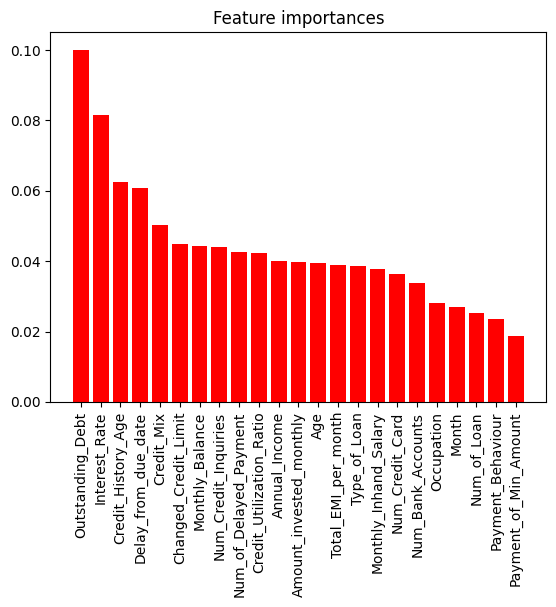

In [193]:
num_features = 23
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], align = 'center', color = 'r')
plt.xticks(range(num_features), feature_names[indices], rotation = 90)
print()

In [194]:
# На основе представленной диаграммы можно сделать значимые выводы о влиянии различных факторов на кредитный рейтинг
# клиентов. Особенно заметно, что размер непогашенного долга и процентная ставка по кредитной карте оказывают
# наибольшее влияние на данный показатель. Эти два параметра выступают в качестве ключевых индикаторов
# финансового здоровья клиентов и, следовательно, их кредитоспособности.
# Чем выше этот долг, тем больше рисков для кредиторов, что, в свою очередь, негативно сказывается на кредитном рейтинге.
# Аналогично, процентная ставка по кредитной карте может отражать уровень кредитного риска, связанного с конкретным клиентом.
# Высокие ставки могут сигнализировать о том, что заемщик имеет низкий кредитный рейтинг или недостаточную финансовую дисциплину.

In [195]:
# Кластеризация

In [196]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

In [197]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_train = scaler.fit_transform(X_train)

In [198]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)
predicted_train_encoded = label_encoder.fit_transform(predictedTrain)
predicted_test_encoded = label_encoder.fit_transform(predictedTest)

In [199]:
print(X_test.shape)
min_values = np.min(X_test, axis=0)
max_values = np.max(X_test, axis=0)
for i in range(X_test.shape[1]):
    print(f"Столбец {i+1}: Минимум = {min_values[i]}, Максимум = {max_values[i]}")

(3000, 23)
Столбец 1: Минимум = -2.668270125528003, Максимум = 1.971911447963338
Столбец 2: Минимум = -0.12619243674046668, Максимум = 14.598262809079067
Столбец 3: Минимум = -1.3015986050331887, Максимум = 3.4991693631481007
Столбец 4: Минимум = -0.1468648574687527, Максимум = 14.134825647372839
Столбец 5: Минимум = -0.18266428076392618, Максимум = 9.443797518545662
Столбец 6: Минимум = -0.1583863952206852, Максимум = 11.495811878404536
Столбец 7: Минимум = -0.11422406997130784, Максимум = 30.3733579635904
Столбец 8: Минимум = -1.4630206749634707, Максимум = 2.9373469097214393
Столбец 9: Минимум = -0.14834352442526666, Максимум = 18.9851613473528
Столбец 10: Минимум = -0.13168599869749034, Максимум = 15.666489261985442
Столбец 11: Минимум = -1.1948851775868323, Максимум = 2.9649962871294635
Столбец 12: Минимум = -2.039022617257699, Максимум = 3.4544773554574215
Столбец 13: Минимум = -2.385787255765842, Максимум = 1.9359815407878478
Столбец 14: Минимум = -0.1463921565324577, Максимум =

In [200]:
kmeans = KMeans(n_clusters=3, random_state=99, init='k-means++')
kmeans.fit(X_train)
train_clusters_kmeans = kmeans.predict(X_train)
test_clusters_kmeans = kmeans.predict(X_test)

In [201]:
dbscan = DBSCAN(eps=2.1, min_samples=12)
train_clusters_dbscan = dbscan.fit(X_train).labels_
test_clusters_dbscan = dbscan.fit(X_test).labels_

print(np.unique(test_clusters_dbscan))

[-1  0  1  2]


In [202]:
optics = OPTICS(max_eps=2.1, min_samples=12)
train_clusters_optics = optics.fit(X_train).labels_
test_clusters_optics = optics.fit(X_test).labels_
print(np.unique(test_clusters_optics))

[-1  0  1  2]


In [203]:
def getMaxFitLabels(test_clusters, target):
  arr = [0, 1, 2]
  all_permutations = list(permutations(arr))
  test_clusters_correct = None
  maxAccuracy = 0
  for i in range(len(all_permutations)):
    test_clusters_tmp = test_clusters
    test_clusters_tmp[test_clusters_tmp == 0] = 3
    test_clusters_tmp[test_clusters_tmp == 1] = 4
    test_clusters_tmp[test_clusters_tmp == 2] = 5
    test_clusters_tmp[test_clusters_tmp == 3] = all_permutations[i][0]
    test_clusters_tmp[test_clusters_tmp == 4] = all_permutations[i][1]
    test_clusters_tmp[test_clusters_tmp == 5] = all_permutations[i][2]
    accuracy_tmp =  accuracy_score(target, test_clusters_tmp)
    if (accuracy_tmp > maxAccuracy):
      test_clusters_correct = test_clusters_tmp
      maxAccuracy = accuracy_tmp
  return maxAccuracy, test_clusters_correct

In [204]:
# сравнение результатов кластеризации с истинными метками KMEANS
kmeansAccuracy, test_clusters_kmeans_correct = getMaxFitLabels(test_clusters_kmeans, y_test_encoded)
kmeans_error = np.mean(test_clusters_kmeans_correct != y_test_encoded)
print("Ошибка: ", kmeans_error)
print("Точность: ", kmeansAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_kmeans_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.7
Точность:  0.5283333333333333
Confusion Matrix:
[[  8 459  92]
 [415 181 330]
 [249 555 711]]


In [205]:
# сравнение результатов кластеризации с метками, полученными во время классификации KMEANS

kmeansAccuracy, test_clusters_kmeans_correct = getMaxFitLabels(test_clusters_kmeans, predicted_test_encoded)
kmeans_error = np.mean(test_clusters_kmeans_correct != y_test_encoded)
print("Ошибка: ", kmeans_error)
print("Точность: ", kmeansAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_kmeans_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.4716666666666667
Точность:  0.5706666666666667
Confusion Matrix:
[[459   8  92]
 [181 415 330]
 [555 249 711]]


In [206]:
# сравнение результатов кластеризации с истинными метками DBSCAN

dbscanAccuracy, test_clusters_dbscan_correct = getMaxFitLabels(test_clusters_dbscan, y_test_encoded)
dbscan_error = np.mean(test_clusters_dbscan_correct != y_test_encoded)
print("Ошибка: ", dbscan_error)
print("Точность: ", dbscanAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_dbscan_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.988
Точность:  0.012666666666666666
Confusion Matrix:
[[   0    0    0    0]
 [ 550    1    3    5]
 [ 913    2    2    9]
 [1454   21    7   33]]


In [207]:
# сравнение результатов кластеризации с метками, полученными во время классификации DBSCAN

dbscanAccuracy, test_clusters_dbscan_correct = getMaxFitLabels(test_clusters_dbscan, predicted_test_encoded)
dbscan_error = np.mean(test_clusters_dbscan_correct != y_test_encoded)
print("Ошибка: ", dbscan_error)
print("Точность: ", dbscanAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_dbscan_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.9873333333333333
Точность:  0.013333333333333334
Confusion Matrix:
[[   0    0    0    0]
 [ 550    3    1    5]
 [ 913    2    2    9]
 [1454    7   21   33]]


In [208]:
# сравнение результатов кластеризации с истинными метками OPTICS

opticsAccuracy, test_clusters_optics_correct = getMaxFitLabels(test_clusters_optics, y_test_encoded)
optics_error = np.mean(test_clusters_optics_correct != y_test_encoded)
print("Ошибка: ", optics_error)
print("Точность: ", opticsAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_optics_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.9896666666666667
Точность:  0.011
Confusion Matrix:
[[   0    0    0    0]
 [ 551    1    3    4]
 [ 914    2    2    8]
 [1460   20    7   28]]


In [209]:
# сравнение результатов кластеризации с метками, полученными во время классификации OPTICS

opticsAccuracy, test_clusters_optics_correct = getMaxFitLabels(test_clusters_optics, predicted_test_encoded)
optics_error = np.mean(test_clusters_optics_correct != y_test_encoded)
print("Ошибка: ", optics_error)
print("Точность: ", opticsAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_optics_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.989
Точность:  0.011333333333333334
Confusion Matrix:
[[   0    0    0    0]
 [ 551    3    1    4]
 [ 914    2    2    8]
 [1460    7   20   28]]


In [210]:
# ВИЗУАЛИЗАЦИЯ

In [211]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

Text(0, 0.5, 'x_2')

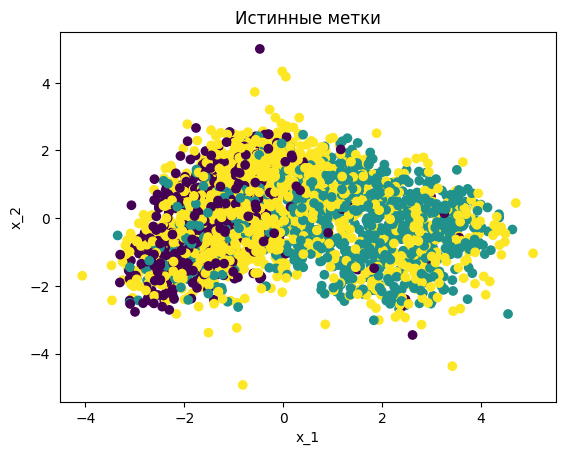

In [212]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_encoded)
plt.title('Истинные метки')
plt.xlabel('x_1')
plt.ylabel('x_2')

Text(0, 0.5, 'x_2')

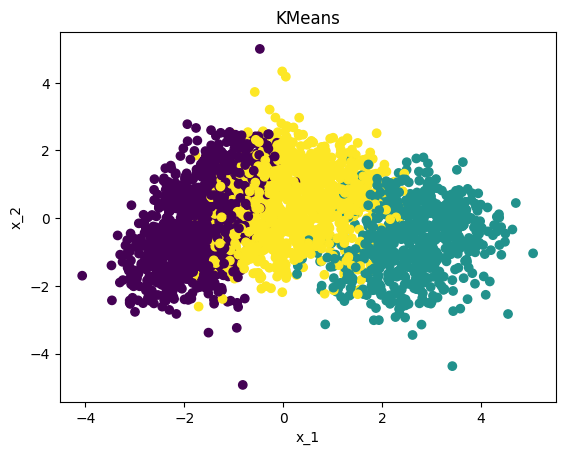

In [213]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters_kmeans)
plt.title('KMeans')
plt.xlabel('x_1')
plt.ylabel('x_2')

Text(0, 0.5, 'x_2')

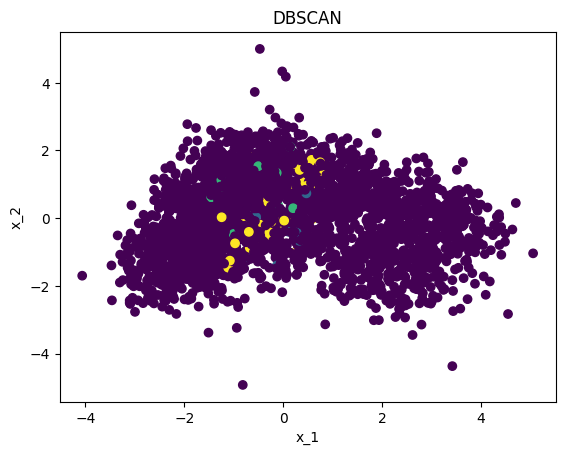

In [214]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters_dbscan)
plt.title('DBSCAN')
plt.xlabel('x_1')
plt.ylabel('x_2')

Text(0, 0.5, 'x_2')

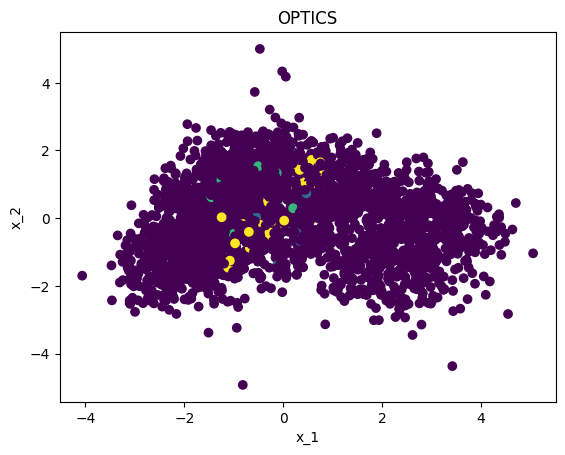

In [215]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters_optics)
plt.title('OPTICS')
plt.xlabel('x_1')
plt.ylabel('x_2')

Плохая точность кластеризации KMeans, DBSCAN и OPTICS, что данные сложны для разбиения, однако мы можем заметить, что KMeans справился с задачей лучше, чем DBSCAN и OPTICS.

Низкую точность кластеризации можно было предсказать на этапе решения задачи классификации, метод ближайших соседей показал крайне плохие результаты (из-за чего был выбран Random Forest).

Возможные причины:

- Признаки недостаточно хорошо разделяют данные.
- Некоторые признаки могут быть слабо связаны с целевым классом.
- Данные содержат большое количество признаков, что может усложнять их анализ для плотностных и линейных методов.
- Структура данных сложна и плохо подходит для традиционных методов кластеризации.

Одним из способов улучшения результатов кластеризации могло бы стать уменьшение количества признаков, так как в процессе анализа данных было выявлено, что некоторые признаки, такие как сумма непогашенного долга и процентная ставка по кредитной карте, оказывают значительно большее влияние на кредитный рейтинг клиентов по сравнению с другими.

Это указывает на то, что не все признаки одинаково важны для решения задачи, и многие из них могут быть нерелевантны или слабо связаны с целевой переменной. Удаление низкоинформативных признаков или применение методов отбора признаков могло бы не только снизить шум в данных, но и упростить их структуру, что, в свою очередь, могло бы повысить точность кластеризации. Кроме того, уменьшение размерности данных способствовало бы более эффективной работе методов, особенно плотностных, таких как DBSCAN и OPTICS, которые чувствительны к высокоразмерным пространствам.